# Generate point source maps with pixell and convert to HEALPix

Testing the pixell `sim_objects` functionality to create maps of point sources pre-smoothed with a gaussian beam.
The purpose is to include this functionality in PySM to be able to generate on the fly maps of source starting from a catalog.

Compared to the [previous notebook](./2024-05-02-pysm-point-source-pixell.ipynb), here I also use `reproject` to convert the map to HEALPix, plot the result and check the flux in HEALPix also agrees with the input.

In [1]:
from pixell import enmap, utils, resample, curvedsky as cs, reproject, pointsrcs
import numpy as np
import healpy as hp

In [2]:
fwhm = 5 * utils.degree

In [3]:
shape, wcs = enmap.fullsky_geometry(res=fwhm / 3, proj="car")

In [4]:
shape

(109, 216)

In [5]:
def fwhm2sigma(fwhm):
    return fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))

In [6]:
def flux2amp(flux, fwhm):
    sigma = fwhm2sigma(fwhm)
    return flux / (2 * np.pi * sigma**2)

In [7]:
assert flux2amp((2 * np.pi * fwhm2sigma(5) ** 2), 5) == 1

In [8]:
n_sources = 1
flux_sources = np.arange(n_sources) + 10

In [9]:
amplitude_sources = flux2amp(flux_sources, fwhm)

In [42]:
source_pos = np.array([[np.pi/4], [np.pi/3]])

In [43]:
r, p = pointsrcs.expand_beam(fwhm2sigma(fwhm))

In [44]:
source_map = pointsrcs.sim_objects(shape, wcs, source_pos, amplitude_sources, ((r, p)))

In [45]:
import matplotlib.pyplot as plt

In [46]:
source_pos

array([[0.78539816],
       [1.04719755]])

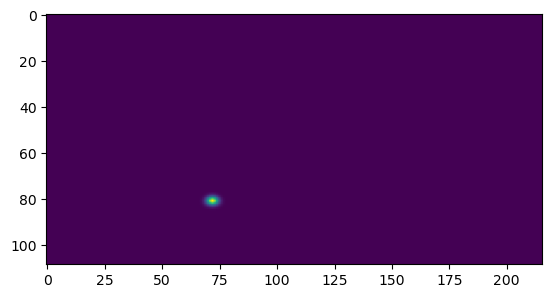

In [47]:
plt.imshow(source_map)

In [48]:
def aperture_photometry(
    thumbs, aperture_radius, annulus_width=None, modrmap=None, pixsizemap=None
):
    """
    Flux from aperture photometry.

    from https://github.com/msyriac/orphics/blob/master/orphics/maps.py

    Parameters
    ----------
    thumb : ndmap
        An (...,Ny,Nx) ndmap (i.e. a pixell enmap) containing the thumbnails.
    aperture_radius : float
        Aperture inner radius in radians
    annulus_width : float
        Annulus width for mean subtraction in radians.
        Defaults to sqrt(2)-1 times the aperture inner radius.
    modrmap : ndmap, optional
        An (Ny,Nx) ndmap containing distances of each pixel from the center in radians.
    modrmap : ndmap, optional
        An (Ny,Nx) ndmap containing pixel areas in steradians.

    Returns
    -------
    flux : ndarray
        (...,) array of aperture photometry fluxes.

    """
    if modrmap is None:
        modrmap = thumbs.modrmap()
    if annulus_width is None:
        annulus_width = (np.sqrt(2.0) - 1.0) * aperture_radius
    # Get the mean background level from the annulus
    mean = thumbs[
        ...,
        np.logical_and(
            modrmap > aperture_radius, modrmap < (aperture_radius + annulus_width)
        ),
    ].mean()
    if pixsizemap is None:
        pixsizemap = thumbs.pixsizemap()
    # Subtract the mean, multiply by pixel areas and sum
    return (((thumbs - mean) * pixsizemap)[..., modrmap <= aperture_radius]).sum(
        axis=-1
    )

In [49]:
from astropy import units as u

In [50]:
box_half_size_rad = 2 * fwhm
box_center = [source_pos[0, -1], source_pos[1, -1]]
box = np.array(
    [
        [box_center[0] - box_half_size_rad, box_center[1] - box_half_size_rad],
        [box_center[0] + box_half_size_rad, box_center[1] + box_half_size_rad],
    ]
)  # in radians

In [51]:
box_center

[0.7853981633974483, 1.0471975511965976]

In [52]:
cutout = source_map.submap(box)

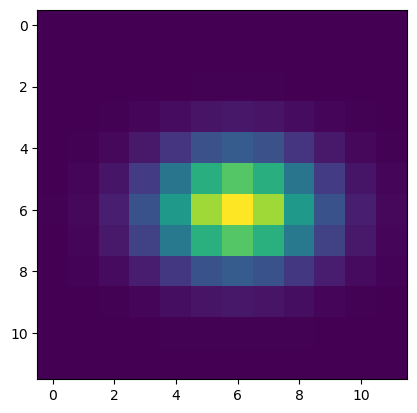

In [53]:
plt.imshow(cutout)

In [54]:
aperture_photometry(cutout, 2 * fwhm)

9.982631206252375

In [55]:
fwhm/3

0.02908882086657216

In [56]:
from pixell import reproject

source_map_healpix = reproject.map2healpix(source_map)

In [57]:
hp.npix2nside(source_map_healpix.size)

64

In [58]:
hp.nside2resol(_)

0.015989479811663883

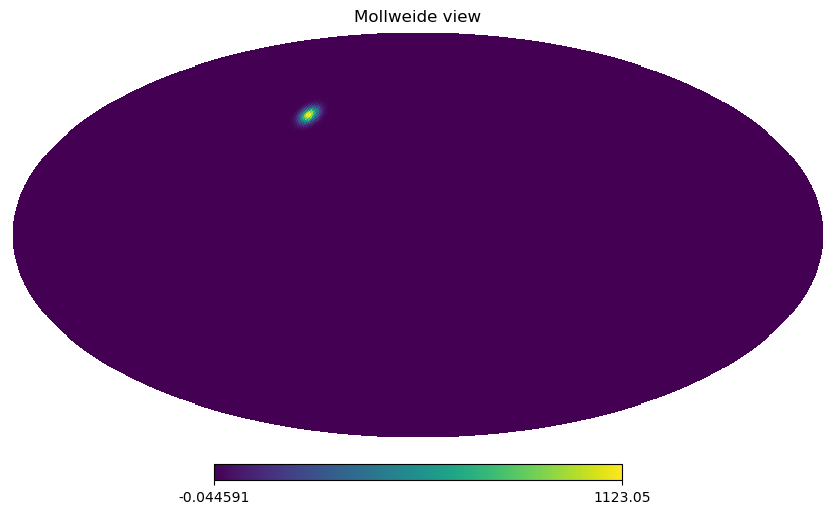

In [59]:
hp.mollview(source_map_healpix)

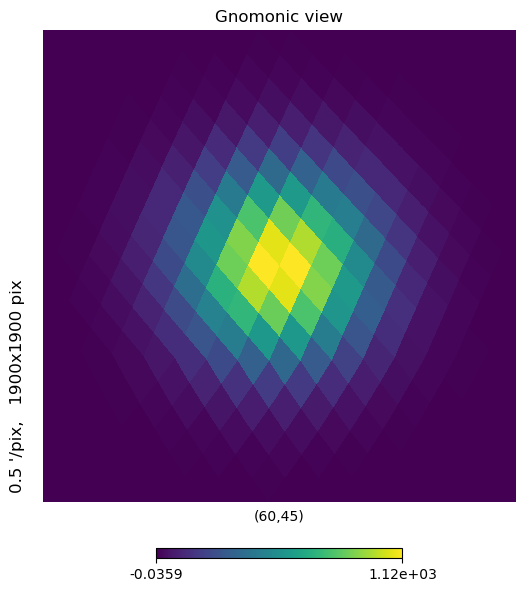

In [60]:

hp.gnomview(source_map_healpix, rot=hp.vec2ang(hp.ang2vec(source_pos[0], source_pos[1]), lonlat=True), xsize=1900, reso=.5)

In [61]:
from pysm3.utils import healpix_aperture_photometry

healpix_aperture_photometry(source_map_healpix, source_pos[0,0], source_pos[1,0], 2 * fwhm)

9.995092243734167